#Instalación de pip

In [66]:
%pip install gurobipy
%pip install amplpy pandas numpy matplotlib tqdm
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(modules=["gurobi"], license_uuid="bb2c71f6-2b4c-4570-8eaf-4db0b0d7349a")

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\gabop\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\gabop\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Licensed to Bundle #6733.7184 expiring 20241231: ICI5142-01 INVESTIGACION DE OPERACIONES AVANZADAS (Advanced Operations Research), Prof. Guillermo Cabrera-Guerrero, Pontificia Universidad Catolica de Valparaiso.


#Instalación de archivos


In [67]:
import os
# Crear el directorio de instancias si no existe
os.makedirs('content/instances', exist_ok=True)

#Depuración de datos

In [68]:
import re
def procesar_archivo(file_path, marker):
    match marker:
        case 1:
            # Función para convertir números en notación científica o float
            def convertir_exponencial(valor):
                try:
                    return float(valor)
                except ValueError:
                    return None

            # Abrimos y leemos el archivo
            with open(file_path, 'r') as f:
                contenido = f.read()

            # Dividimos las secciones por el delimitador "*"
            secciones = contenido.split('*')

            # Eliminamos espacios en blanco adicionales
            secciones = [seccion.strip() for seccion in secciones if seccion.strip()]

            # Primera sección: número de instalaciones y clientes
            primera_linea = secciones[0].splitlines()[0]
            m, n = map(int, primera_linea.split())
            print(f"Número de almacenes (m): {m}, Número de clientes (n): {n}")

            # Inicializamos la estructura para los datos
            datos = {
                'num_warehouses': m,
                'num_customers': n,
                'warehouses': [],  # Capacidad y costo fijo
                'customer_demands': [],  # Demandas de clientes
                'allocation_costs': []   # Costos de asignación
            }

            # Segunda sección: datos de los almacenes (capacidad y costo fijo)
            almacenes_lineas = secciones[1].splitlines()
            for linea in almacenes_lineas:
                valores = linea.split()
                if len(valores) == 2:
                    capacidad, costo_fijo = map(convertir_exponencial, valores)
                    datos['warehouses'].append({
                        'capacity': capacidad,
                        'fixed_cost': costo_fijo
                    })

            # Tercera sección: demandas de clientes
            demandas_lineas = secciones[2].splitlines()
            datos['customer_demands'] = [convertir_exponencial(d) for d in demandas_lineas if d]

            # Cuarta sección: matriz de costos de asignación
            costos_lineas = secciones[3].splitlines()
            for linea in costos_lineas:
                costos = [convertir_exponencial(valor) for valor in linea.split()]
                datos['allocation_costs'].append(costos)

            # Verificamos que las dimensiones de los costos coincidan con m x n
            if len(datos['allocation_costs']) != datos['num_warehouses']:
                raise ValueError("El número de filas en la matriz de costos no coincide con el número de almacenes.")
            for fila in datos['allocation_costs']:
                if len(fila) != datos['num_customers']:
                    raise ValueError("El número de columnas en la matriz de costos no coincide con el número de clientes.")

            return datos

        case 2:
           # Abrimos el archivo para lectura
              data = {}

              with open(file_path, 'r') as file:
                  lines = file.readlines()

              # Leer número de instalaciones y clientes
              n_warehouses, n_customers = map(int, lines[0].split())
              data['num_warehouses'] = n_warehouses
              data['num_customers'] = n_customers

              capacities = []
              fixed_costs = []
              for i in range(1, n_warehouses + 1):
                  capacity, fixed_cost = map(float, lines[i].split())
                  capacities.append(capacity)
                  fixed_costs.append(fixed_cost)
              # Leer demandas de clientes
              demand_lines = lines[n_warehouses + 1:]  # Empieza a leer después de los almacenes
              data1 = [item.strip() for item in demand_lines]

              # Definir listas para almacenar los resultados
              allocation_costs = []
              temp_group = []
              demands = []
              # Iterar a través de los elementos
              for item in data1:
                  # Si el item es un valor "solo" (un número único), lo agregamos a la lista final
                  if item.isdigit():
                      if temp_group:  # Si ya tenemos elementos en el grupo, lo agregamos a los resultados
                          allocation_costs.append(temp_group)
                          temp_group = []  # Reiniciar el grupo
                      demands.append(int(item))
                  else:
                      numbers = item.split()  # Esto crea una lista de cadenas
                      for number in numbers:
                          temp_group.append(float(number))
              allocation_costs.append(temp_group)
              assert len(capacities) == n_warehouses, "FALLO: N de capacidades no coincide con el número de instalaciones."
              assert len(fixed_costs) == n_warehouses, "FALLO: N de costos fijos no coincide con el número de instalaciones."
              assert len(demands) == n_customers, "FALLO: N de demandas no coincide con el número de clientes."
              assert len(allocation_costs) == n_customers, "FALLO: N de filas en la matriz de costos variables no coincide con el número de clientes."
              for row in allocation_costs:
                  assert len(row) == n_warehouses, "FALLO: N de columnas en la matriz de costos variables no coincide con el número de instalaciones."

              data['warehouses'] = [{'capacity': capacities[i], 'fixed_cost': fixed_costs[i]} for i in range(n_warehouses)]
              data['customer_demands'] = demands
              data['allocation_costs'] = allocation_costs

              return data

        case _:
            # Caso por defecto para marcadores no manejados
            raise ValueError(f"Marcador no reconocido: {marker}")


#Solver CLFP

In [ ]:
from typing import Dict
import numpy as np
from amplpy import AMPL

class CFLP_Hybrid_Solver:
    def __init__(self, data_dict: dict, single_source: bool = True):
        # Extraer datos del diccionario
        self.n_facilities = data_dict['num_warehouses']
        self.n_customers = data_dict['num_customers']
        self.fixed_costs = [w['fixed_cost'] for w in data_dict['warehouses']]
        self.capacities = [w['capacity'] for w in data_dict['warehouses']]
        self.demands = data_dict['customer_demands']
        self.variable_costs = data_dict['allocation_costs']

        self.single_source = single_source
        self.ampl = AMPL()

        # Configurar el solver
        self.ampl.setOption('solver', 'gurobi')
        self._setup_ampl_models()
    
    def _setup_ampl_models(self):
        # Modelo para Single Source Capacitated Facility Location Problem (SSCFLP)
        sscflp_model = """
        set FACILITIES;
        set CUSTOMERS;

        param fixed_cost{FACILITIES} >= 0;
        param capacity{FACILITIES} >= 0;
        param demand{CUSTOMERS} >= 0;
        param var_cost{FACILITIES, CUSTOMERS} >= 0;

        var y{FACILITIES} binary;
        var x{FACILITIES, CUSTOMERS} binary;

        minimize Total_Cost:
            sum{i in FACILITIES} fixed_cost[i] * y[i] +
            sum{i in FACILITIES, j in CUSTOMERS} var_cost[i,j] * x[i,j];

        subject to Demand_Satisfaction{j in CUSTOMERS}:
            sum{i in FACILITIES} x[i,j] = 1;

        subject to Capacity_Limit{i in FACILITIES}:
            sum{j in CUSTOMERS} demand[j] * x[i,j] <= capacity[i] * y[i];
        """
        # Modelo para Multicommodity Source Capacitated Facility Location Problem (MSCFLP)
        mscflp_model = """
        set FACILITIES;
        set CUSTOMERS;

        param fixed_cost{FACILITIES} >= 0;
        param capacity{FACILITIES} >= 0;
        param demand{CUSTOMERS} >= 0;
        param var_cost{FACILITIES, CUSTOMERS} >= 0;

        var y{FACILITIES} binary;
        var x{FACILITIES, CUSTOMERS} >= 0;

        minimize Total_Cost:
            sum{i in FACILITIES} fixed_cost[i] * y[i] +
            sum{i in FACILITIES, j in CUSTOMERS} var_cost[i,j] * x[i,j];

        subject to Demand_Satisfaction{j in CUSTOMERS}:
            sum{i in FACILITIES} x[i,j] = demand[j];

        subject to Capacity_Limit{i in FACILITIES}:
            sum{j in CUSTOMERS} x[i,j] <= capacity[i] * y[i];
        """        
        
        
        
        
        
        
        """ELECCÓN DE MODELO PARA RESOLVER EL PROBLEMA
        
        AQUIIII"""
        
        #Escribir y leer modelo en archivo SSCFLP
        with open('sscflp.mod', 'w') as f:
            f.write(sscflp_model)
        self.ampl.read('sscflp.mod')#"""
        
        """#Escribir y leer modelo en archivo MSCFLP
        with open('mscflp.mod', 'w') as f:
            f.write(mscflp_model)
        self.ampl.read('mscflp.mod')#"""
        
        """ELECCÓN DE MODELO PARA RESOLVER EL PROBLEMA
        
        AQUIIII"""
        
        
        
        
        
        
            
        self.ampl.set['FACILITIES'] = range(1, self.n_facilities + 1)
        self.ampl.set['CUSTOMERS'] = range(1, self.n_customers + 1)

        self.ampl.param['fixed_cost'] = {i+1: cost for i, cost in enumerate(self.fixed_costs)}
        self.ampl.param['capacity'] = {i+1: cap for i, cap in enumerate(self.capacities)}
        self.ampl.param['demand'] = {i+1: dem for i, dem in enumerate(self.demands)}
        self.ampl.param['var_cost'] = {(i+1, j+1): self.variable_costs[j][i]
                                      for i in range(self.n_facilities)
                                      for j in range(self.n_customers)}


    def _branch_and_bound(self):
        # Implementación de Branch and Bound
        best_solution = np.random.choice([0, 1], size=self.n_facilities, p=[0.7, 0.3])
        best_cost = self._evaluate_solution(best_solution)

        for i in range(self.n_facilities):
            neighbor = best_solution.copy()
            neighbor[i] = 1 - neighbor[i]

            # Evaluar solución vecina
            neighbor_cost = self._evaluate_solution(neighbor)

            if neighbor_cost < best_cost:
                best_solution = neighbor
                best_cost = neighbor_cost

        return best_solution, best_cost

    def _tabu_search(self, initial_solution, max_iter=10, tabu_size=10):
    #def _tabu_search(self, initial_solution, max_iter, tabu_size):
        # Implementación de Tabu Search
        current_solution = initial_solution
        best_solution = current_solution
        best_cost = self._evaluate_solution(current_solution)

        tabu_list = []
        history = [best_cost]

        for _ in range(max_iter):
            # Generar vecindario
            neighbors = []
            for i in range(self.n_facilities):
                neighbor = current_solution.copy()
                neighbor[i] = 1 - neighbor[i]
                if tuple(neighbor) not in tabu_list:
                    neighbors.append(neighbor)

            # Evaluar vecindario
            neighbor_costs = [self._evaluate_solution(n) for n in neighbors]
            min_neighbor_idx = np.argmin(neighbor_costs)
            
            current_solution = neighbors[min_neighbor_idx]
            current_cost = neighbor_costs[min_neighbor_idx]

            # Actualizar solución y lista tabú
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            tabu_list.append(tuple(current_solution))
            if len(tabu_list) > tabu_size:
                tabu_list.pop(0)

            history.append(best_cost)

        return best_solution, best_cost, history

    def solve(self, max_iter=100, solve_method='hybrid'):
    #def solve(self, max_iter, solve_method):
        # Método híbrido: Branch and Bound seguido de Tabu Search
        print("Ejecutando Branch and Bound...")
        bb_solution, bb_cost = self._branch_and_bound()
        print(f"Branch and Bound: Costo inicial = {bb_cost}")

        print("Refinando con Tabu Search...")
        tabu_solution, tabu_cost, history = self._tabu_search(bb_solution, max_iter)
        print(f"Tabu Search: Costo final = {tabu_cost}")

        return {
            'facilities': [i for i, v in enumerate(tabu_solution) if v == 1],
            'cost': tabu_cost,
            'history': history
        }

    def _evaluate_solution(self, solution: np.ndarray) -> float:
        # Evaluar la solución en el modelo de AMPL
        for i in range(self.n_facilities):
            self.ampl.getVariable('y')[i+1].fix(solution[i])

        try:
            self.ampl.solve()
            return self.ampl.getObjective('Total_Cost').value()
        except:
            return float('inf')
        finally:
            for i in range(self.n_facilities):
                self.ampl.getVariable('y')[i+1].unfix()

#Resultados


Procesando cap51.txt... (1/1 - 100.00%)
Marcador asignado: 2
Datos leídos correctamente. Instalaciones: 16, Clientes: 50
Ejecutando Branch and Bound...
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all variables eliminated, but lower bound = 1 > 0
	presolve, constraint Demand_Satisfaction[34]:
		all va

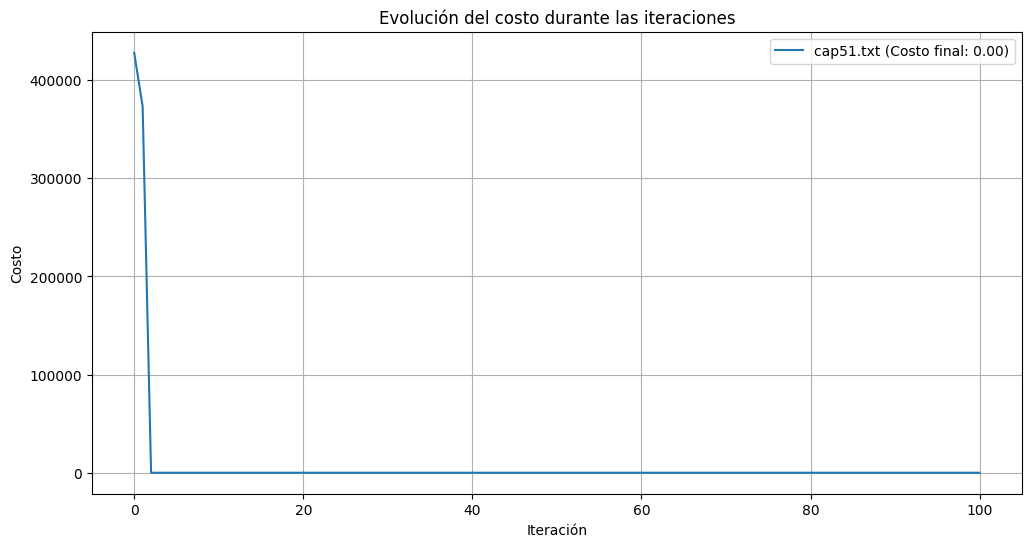

Resultados exportados exitosamente a 'resultados\resultados.csv'


In [70]:
import os
import matplotlib.pyplot as plt
import re
import csv

def plot_results(results_orlib):
    plt.figure(figsize=(12, 6))

    if not results_orlib:
        plt.text(0.5, 0.5, 'No hay datos para mostrar',
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=plt.gca().transAxes)
    else:
        for result in results_orlib:
            instance_name = os.path.basename(result['instance'])
            if 'history' in result and result['history']:
                plt.plot(result['history'], label=f"{instance_name} (Costo final: {result['final_cost']:.2f})")

    plt.title("Evolución del costo durante las iteraciones")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)

    if len(plt.gca().lines) > 0:
        plt.legend()

    plt.show()

def main():
    # Parámetros para el solver
    params = {
        'max_iter': 100,  # Número máximo de iteraciones para Tabu Search
        'solve_method': 'hybrid'  # Método de resolución: 'branch_and_bound', 'tabu_search' o 'hybrid'
    }

    # Lista para almacenar resultados
    results_orlib = []

    # Crear carpeta para resultados
    results_folder = "resultados"
    os.makedirs(results_folder, exist_ok=True)

    # Ruta por defecto para las instancias
    pathDef = "cd/../content/instances"

    # Solicitar por pantalla la lista de instancias
    instance_files = input("Ingrese los nombres de los archivos separados por coma: ").split(",")
    
    # Eliminar espacios en blanco
    instance_files = [instance.strip() for instance in instance_files]
    total_instances = len(instance_files)

    # Procesar cada instancia
    for idx, instance_file in enumerate(instance_files):
        try:
            # Concatenar ruta
            full_path = os.path.join(pathDef, instance_file)

            # Verificar si el archivo existe
            if not os.path.isfile(full_path):
                print(f"El archivo '{instance_file}' no existe en la ruta especificada. Saltando...")
                continue

            print(f"\nProcesando {instance_file}... ({idx + 1}/{total_instances} - {((idx + 1) / total_instances) * 100:.2f}%)")

            # Determinar marcador usando expresiones regulares
            if re.search(r"\d+x\d+_\d+", instance_file):  # Patrón similar a "1x1_1"
                marker = 1
            elif re.search(r"cap\d+", instance_file):  # Patrón "cap" seguido de cualquier número
                marker = 2 
            elif re.search(r"cap[a-zA-Z]+", instance_file):  # Patrón "cap" seguido de letras
                marker = 3           
            else:
                marker = 0  # Sin patrón definido

            print(f"Marcador asignado: {marker}")

            # Leer datos del archivo
            data = procesar_archivo(full_path, marker)

            print(f"Datos leídos correctamente. Instalaciones: {data['num_warehouses']}, Clientes: {data['num_customers']}")

            # Crear instancia del solver y resolver
            solver = CFLP_Hybrid_Solver(data, single_source=True)
            result = solver.solve(**params)

            # Almacenar resultados
            results_orlib.append({
                "instance": instance_file,
                "marker": marker,
                "history": result['history'],
                "final_cost": result['cost'],
                "selected_facilities": result['facilities']
            })

            print(f"Instancia procesada. Costo final: {result['cost']}")

        except Exception as e:
            print(f"Error procesando {instance_file}: {str(e)}")
    
    # Graficar resultados
    plot_results(results_orlib)

    # Guardar resultados en archivo CSV
    results_path = os.path.join(results_folder, "resultados.csv")
    try:
        with open(results_path, mode="w", newline="") as results_file:
            csv_writer = csv.writer(results_file)
            # Escribir encabezados
            csv_writer.writerow(["Instancia", "Marcador", "Costo final", "Instalaciones seleccionadas", "Historia del costo"])
            
            # Escribir filas
            for result in results_orlib:
                csv_writer.writerow([
                    result["instance"],
                    result["marker"],
                    result["final_cost"],
                    ";".join(map(str, result["selected_facilities"])),  # Lista como string separada por ";"
                    ";".join(map(str, result["history"]))  # Historia del costo como string separada por ";"
                ])
            print(f"Resultados exportados exitosamente a '{results_path}'")
    except Exception as e:
        print(f"Error al guardar los resultados: {str(e)}")

if __name__ == "__main__":
    main()

